In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [23]:
x_item_train = pd.read_csv('../../../data/input_formated/final/x_item_train.csv').iloc[:, 1:]
x_user_train = pd.read_csv('../../../data/input_formated/final/x_user_train.csv').iloc[:, 1:]
y_train = pd.read_csv('../../../data/input_formated/final/y_train.csv').iloc[:, 1:]

In [24]:
x_item_val = pd.read_csv('../../../data/input_formated/final/x_item_val.csv').iloc[:, 1:]
x_user_val = pd.read_csv('../../../data/input_formated/final/x_user_val.csv').iloc[:, 1:]
y_val_df = pd.read_csv('../../../data/input_formated/final/y_val.csv').iloc[:, 1:]
y_val = y_val_df

In [25]:
item_features = [u'category_Action', u'category_Adventure',
       u'category_Animation', u'category_Children\'s', u'category_Comedy',
       u'category_Crime', u'category_Documentary', u'category_Drama',
       u'category_Fantasy', u'category_Film-Noir', u'category_Horror',
       u'category_Musical', u'category_Mystery', u'category_Romance',
       u'category_Sci-Fi', u'category_Thriller', u'category_War',
       u'category_Western']

In [26]:
user_features = [u'occupation_0', u'occupation_1',
       u'occupation_2', u'occupation_3', u'occupation_4', u'occupation_5',
       u'occupation_6', u'occupation_7', u'occupation_8', u'occupation_9',
       u'occupation_10', u'occupation_11', u'occupation_12', u'occupation_13',
       u'occupation_14', u'occupation_15', u'occupation_16', u'occupation_17',
       u'occupation_18', u'occupation_19', u'occupation_20', u'age',
       u'gender']

In [27]:
target_features = ['rating']

In [28]:
x_0_train = np.array(x_item_train[item_features], dtype = np.float32)
x_1_train = np.array(x_user_train[user_features], dtype = np.float32)
y_train = np.array(y_train[target_features], dtype=np.float32).reshape((-1, 1))

In [29]:
x_0_val = np.array(x_item_val[item_features], dtype = np.float32)
x_1_val = np.array(x_user_val[user_features], dtype = np.float32)
y_val = np.array(y_val[target_features], dtype=np.float32).reshape((-1, 1))

# ANN

In [10]:
class ANN_2input(nn.Module):
    def __init__(self, input_0_size, input_1_size, hidden_size, output_size):
        super(ANN_2input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, hidden_size) 
        self.fc1 = nn.Linear(input_1_size, hidden_size)  
        self.activate0 = nn.Sigmoid()
        self.activate1 = nn.Sigmoid()
        self.fc_merge0 = nn.Linear(hidden_size, hidden_size)
        self.fc_merge1 = nn.Linear(hidden_size, hidden_size)
        self.bn_merge = nn.BatchNorm1d(hidden_size,hidden_size)
        self.activate_merge = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x_0, x_1):
        h_0 = self.activate0(self.fc0(x_0))
        h_1 = self.activate1(self.fc1(x_1))
        h = self.activate_merge(self.bn_merge(self.fc_merge0(h_0) + self.fc_merge1(h_1)))
        return self.activate(self.bn(self.fc(h)))

# Train

In [11]:
def mse_loss_vector(a, b):
    return torch.abs((a - b) * (a-b)).mean(dim = 0)

In [12]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [30]:
def val_error(model):
    inputs_0 = Variable(torch.from_numpy(np.array(x_0_val, dtype = np.float32)))
    inputs_1 = Variable(torch.from_numpy(np.array(x_1_val, dtype = np.float32)))
    outputs = model(inputs_0, inputs_1).data[:,0]
    tmp = y_val_df
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index() * 5, dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index() * 5, dtype = np.float32)[: ,1].reshape((-1,1))
    return np.sqrt(np.mean((target - output) * (target - output)))

In [19]:
def train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val, learning_rate, num_epochs, old_epochs, hidden_size, check_point = 100, model = None, model_save = None, max_patience = 200):
    if model is None:
        model = ANN_2input(x_0_train.shape[1], x_1_train.shape[1], hidden_size, y_train.shape[1])
    
    # Loss and Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    train_loss_list, val_loss_list = [], []

    #early stopping
    patience = 0
    best_val = None
    model_best = None 
    
    # Train the Model 
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs_0 = Variable(torch.from_numpy(x_0_train))
        inputs_1 = Variable(torch.from_numpy(x_1_train))
        targets = Variable(torch.from_numpy(y_train), requires_grad = False)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        outputs = model(inputs_0, inputs_1)
        train_loss = mse_loss_vector(outputs, targets).sum()
        
        train_loss_list.append(train_loss.data[0])

        #validate
        inputs_0 = Variable(torch.from_numpy(x_0_val))
        inputs_1 = Variable(torch.from_numpy(x_1_val))
        targets = Variable(torch.from_numpy(y_val), requires_grad = False)
        outputs = model(inputs_0,inputs_1)   
        val_loss = mse_loss_vector(outputs, targets).sum()
        val_loss_list.append(val_loss.data[0])
        val_err = val_error(model)

        train_loss.backward()
        optimizer.step()

        if (epoch == 0) or ((epoch+1) % check_point == 0):
            print ('Epoch [%d/%d], Loss: %.4f, %.4f, Val Error: %.4f' 
                   %(epoch+1+old_epochs, num_epochs + old_epochs, train_loss.data[0], val_loss.data[0], val_err))
            if model_save is not None:
                torch.save(model, '%s_%d.pth' % (model_save, epoch + 1 + old_epochs))
        if (best_val is None) or ((best_val is not None) and (val_err < best_val)) :
            best_val = val_err.data[0]
            patience = max_patience
            model_best = model
#             print 'Optimal: %d' % (epoch+1 + 5000)
        else:
            patience -= 1
        if patience == 0:
            print 'Early stopping at %d' % (epoch +1+ old_epochs)
            break            

    #Plot the graph
    plt.plot(range(len(val_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label ='validate')
    
    plt.legend()
    plt.show()
    
    return model_best

Epoch [1/1000], Loss: 0.0971, 0.0943


/home/anla/Apps/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ANN_2input. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [10/1000], Loss: 0.0878, 0.0852
Epoch [20/1000], Loss: 0.0786, 0.0761
Epoch [30/1000], Loss: 0.0707, 0.0682
Epoch [40/1000], Loss: 0.0646, 0.0623
Epoch [50/1000], Loss: 0.0600, 0.0581
Epoch [60/1000], Loss: 0.0565, 0.0550
Epoch [70/1000], Loss: 0.0541, 0.0528
Epoch [80/1000], Loss: 0.0523, 0.0511
Epoch [90/1000], Loss: 0.0510, 0.0499
Epoch [100/1000], Loss: 0.0501, 0.0491
Epoch [110/1000], Loss: 0.0494, 0.0486
Epoch [120/1000], Loss: 0.0489, 0.0482
Epoch [130/1000], Loss: 0.0486, 0.0480
Epoch [140/1000], Loss: 0.0483, 0.0478
Epoch [150/1000], Loss: 0.0482, 0.0478
Epoch [160/1000], Loss: 0.0480, 0.0477
Epoch [170/1000], Loss: 0.0479, 0.0477
Epoch [180/1000], Loss: 0.0478, 0.0477
Epoch [190/1000], Loss: 0.0476, 0.0477
Epoch [200/1000], Loss: 0.0475, 0.0477
Epoch [210/1000], Loss: 0.0473, 0.0478
Epoch [220/1000], Loss: 0.0472, 0.0479
Epoch [230/1000], Loss: 0.0470, 0.0480
Epoch [240/1000], Loss: 0.0468, 0.0480
Epoch [250/1000], Loss: 0.0467, 0.0480
Epoch [260/1000], Loss: 0.0465, 0.

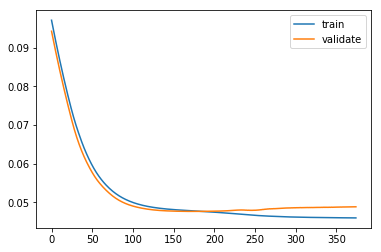

In [16]:
model_ex1 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.01, num_epochs= 1000, old_epochs = 0, hidden_size = 10, check_point = 10, model_save='final_with-user/ex-1')

Epoch [1/1000], Loss: 0.0971, 0.0943, Val Error: 0.9977


/home/anla/Apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error


Epoch [10/1000], Loss: 0.0961, 0.0933, Val Error: 0.9895
Epoch [20/1000], Loss: 0.0951, 0.0923, Val Error: 0.9804
Epoch [30/1000], Loss: 0.0940, 0.0912, Val Error: 0.9714
Epoch [40/1000], Loss: 0.0930, 0.0902, Val Error: 0.9625
Epoch [50/1000], Loss: 0.0919, 0.0892, Val Error: 0.9536
Epoch [60/1000], Loss: 0.0909, 0.0882, Val Error: 0.9447
Epoch [70/1000], Loss: 0.0899, 0.0872, Val Error: 0.9357
Epoch [80/1000], Loss: 0.0889, 0.0862, Val Error: 0.9266
Epoch [90/1000], Loss: 0.0879, 0.0853, Val Error: 0.9174
Epoch [100/1000], Loss: 0.0869, 0.0843, Val Error: 0.9079
Epoch [110/1000], Loss: 0.0860, 0.0833, Val Error: 0.8981
Epoch [120/1000], Loss: 0.0850, 0.0823, Val Error: 0.8879
Epoch [130/1000], Loss: 0.0840, 0.0813, Val Error: 0.8774
Epoch [140/1000], Loss: 0.0830, 0.0804, Val Error: 0.8665
Epoch [150/1000], Loss: 0.0821, 0.0794, Val Error: 0.8554
Epoch [160/1000], Loss: 0.0812, 0.0784, Val Error: 0.8442
Epoch [170/1000], Loss: 0.0803, 0.0775, Val Error: 0.8333
Epoch [180/1000], Loss:

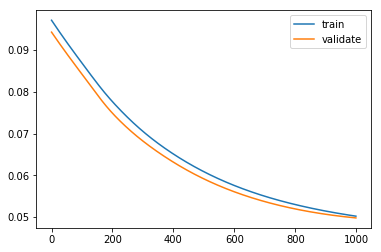

In [31]:
model_ex2 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.001, num_epochs= 1000, old_epochs = 0, hidden_size = 10, check_point = 10, model_save='final_with-user/ex-2')

In [ ]:
model_ex2 = train(x_0_train, x_1_train, y_train, x_0_val, x_1_val, y_val,  learning_rate = 0.001, num_epochs= 3000, old_epochs = 0, hidden_size = 10, check_point = 10, model_save='final_with-user/ex-2')

# Test

In [ ]:
model2.activate1 = model.activate2

In [ ]:
def test(x_0, x_1, y):
    inputs_0 = Variable(torch.from_numpy(np.array(x_0, dtype = np.float32)))
    inputs_1 = Variable(torch.from_numpy(np.array(x_1, dtype = np.float32)))
    outputs = model2(inputs_0, inputs_1).data[:,0]
    tmp = y
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['mean_rate'].mean().reset_index() * 5, dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index() * 5, dtype = np.float32)[: ,1].reshape((-1,1))
    return np.sqrt(np.mean((target - output) * (target - output)))

In [ ]:
x_item_train.iloc[:, 2:].shape

In [ ]:
test(x_item_train.iloc[:, 2:], x_user_train.iloc[:, 2:], y_train)

In [ ]:
test(x_item_test.iloc[:, 2:], x_user_test.iloc[:, 2:], y_test)